In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from tqdm import tqdm 
from sklearn.decomposition import PCA
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Rest of your code goes here
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Use Sigmoid for final layer to get output in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_latent_vector(self, x):
        return self.encoder(x)
    
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128,  num_workers=8, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128,  num_workers=8, shuffle=False)




In [9]:
from sklearn.manifold import TSNE
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

def save_latent_space(model, device, test_loader, path, num_batches=None, save=True):
    # Extract latent representations
    model.eval()
    label_path = path + "labels.npy"
    latent_path = path + "latent_space.npy"
    
    with torch.no_grad():
        latent_space = []
        labels = []
        batch_count = 0  # Initialize batch counter
        
        for images, digit_labels in test_loader:
            if num_batches is not None and batch_count >= num_batches:
                break  # Stop if the specified number of batches is processed
                
            images = images.to(device)
            latents = model.get_latent_vector(images).cpu().numpy()
            latent_space.append(latents)
            labels.append(digit_labels.cpu().numpy())
            
            batch_count += 1  # Increment batch counter

        latent_space = np.concatenate(latent_space)
        labels = np.concatenate(labels)
        
        # Apply t-SNE to reduce dimensions to 2
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
        pca = PCA(n_components=2)
        latent_2d = tsne.fit_transform(latent_space)
        # latent_2d = pca.fit_transform(latent_space)
        # Normalize latent_2D between 0 and 1 in each direction
        normalized_latent_2D = (latent_2d - np.min(latent_2d, axis=0)) / (np.max(latent_2d, axis=0) - np.min(latent_2d, axis=0))

        # Visualize the latent space
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(normalized_latent_2D[:, 0], normalized_latent_2D[:, 1], c=labels, cmap='tab10', alpha=0.6, edgecolor='k')
        plt.colorbar(scatter)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.title('2D t-SNE Projection of Latent Space')
        plt.show()
        
        if(save):
            np.save(latent_path, latent_2d)
            np.save(label_path, labels)


In [10]:

# Model, Loss Function, Optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader):
        img, _ = data
        img = img.to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
                
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
# os.makedirs(f'images/latent_space8D/{epoch}/', exist_ok=True)
# save_latent_space(model, device, train_loader, path=f'images/latent_space8D/{epoch}/', num_batches=3)


print("Training finished!")

Epoch [1/20], Loss: 0.0520
Epoch [2/20], Loss: 0.0379
Epoch [3/20], Loss: 0.0329
Epoch [4/20], Loss: 0.0310
Epoch [5/20], Loss: 0.0272
Epoch [6/20], Loss: 0.0245
Epoch [7/20], Loss: 0.0249
Epoch [8/20], Loss: 0.0234
Epoch [9/20], Loss: 0.0227
Epoch [10/20], Loss: 0.0215
Epoch [11/20], Loss: 0.0198
Epoch [12/20], Loss: 0.0203
Epoch [13/20], Loss: 0.0201
Epoch [14/20], Loss: 0.0173
Epoch [15/20], Loss: 0.0184
Epoch [16/20], Loss: 0.0157
Epoch [17/20], Loss: 0.0170
Epoch [18/20], Loss: 0.0164
Epoch [19/20], Loss: 0.0173
Epoch [20/20], Loss: 0.0164
Training finished!


/home/modrzyk/miniconda3/envs/Manim/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


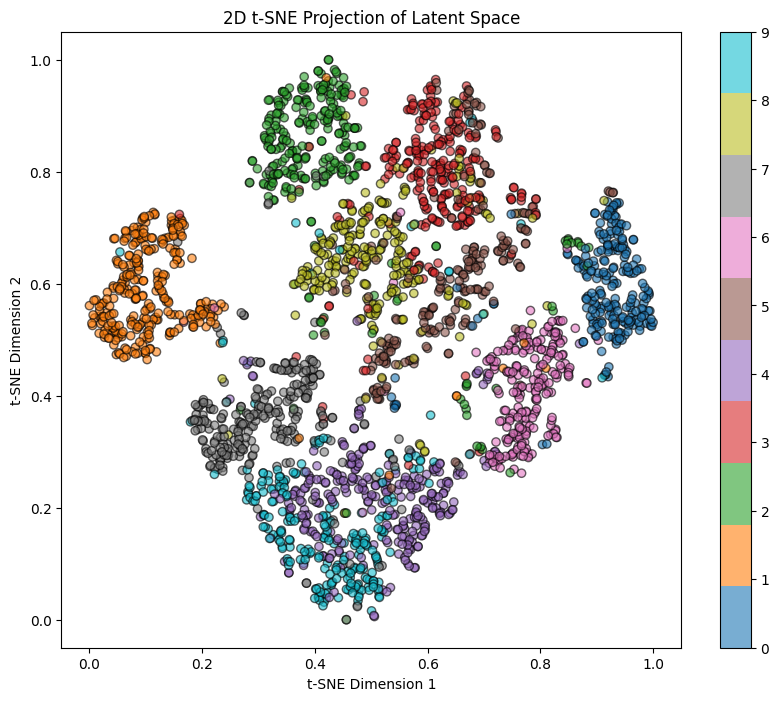

In [11]:
from sklearn.manifold import TSNE
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

# Extract latent representations
model.eval()
num_batches = 20

with torch.no_grad():
    latent_space = []
    labels = []
    batch_count = 0  # Initialize batch counter
    
    for images, digit_labels in test_loader:
        if num_batches is not None and batch_count >= num_batches:
            break  # Stop if the specified number of batches is processed
            
        images = images.to(device)
        latents = model.get_latent_vector(images).cpu().numpy()
        latent_space.append(latents)
        labels.append(digit_labels.cpu().numpy())
        
        batch_count += 1  # Increment batch counter

    latent_space = np.concatenate(latent_space)
    labels = np.concatenate(labels)
    # latent_2d = latent_space
    # Apply t-SNE to reduce dimensions to 2
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000, learning_rate=50, random_state=42)
    latent_2d = tsne.fit_transform(latent_space)
    normalized_latent_2D = (latent_2d - np.min(latent_2d, axis=0)) / (np.max(latent_2d, axis=0) - np.min(latent_2d, axis=0))

    # Visualize the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(normalized_latent_2D[:, 0], normalized_latent_2D[:, 1], c=labels, cmap='tab10', alpha=0.6, edgecolor='k')
    plt.colorbar(scatter)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('2D t-SNE Projection of Latent Space')
    plt.show()

In [12]:
path = f'data/latent/'

label_path = path + "labels.npy"
latent_path = path + "latent_space.npy"
    
np.save(latent_path, normalized_latent_2D)
np.save(label_path, labels)


0.16637022793293 0.08120939135551453 0.13791629672050476


/home/modrzyk/miniconda3/envs/Manim/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([784])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


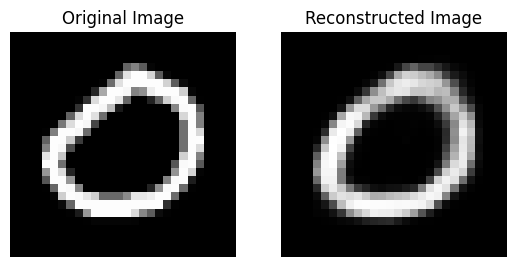

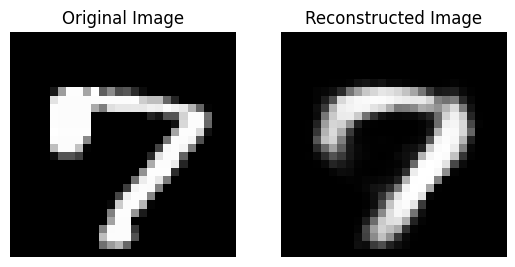

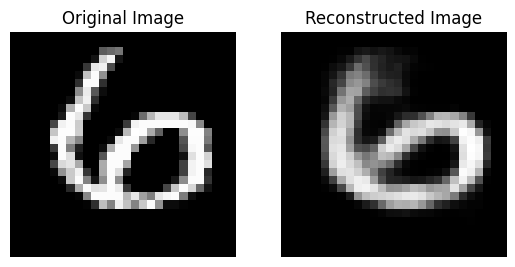

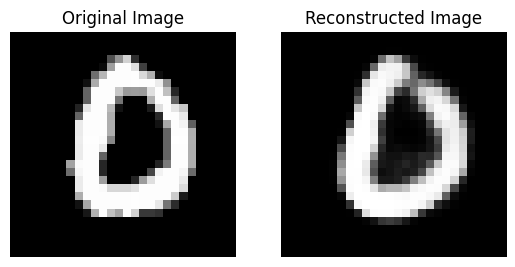

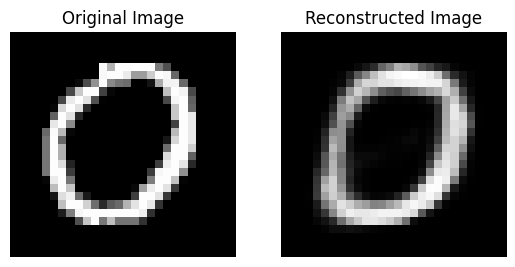

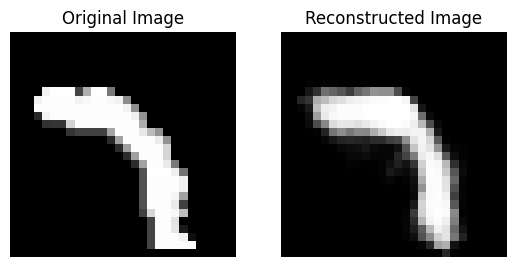

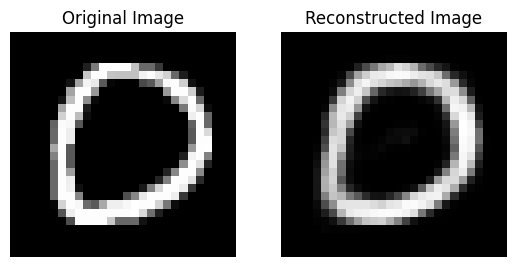

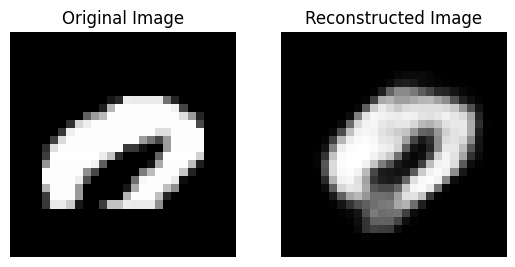

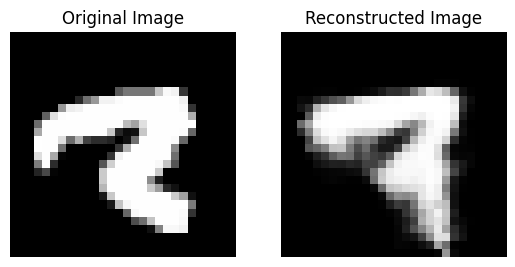

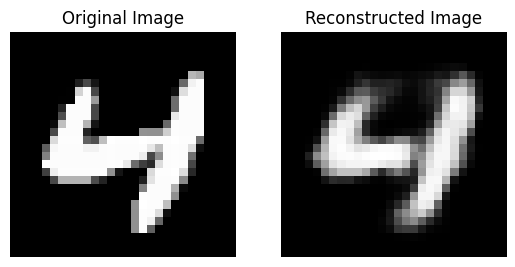

FileNotFoundError: [Errno 2] No such file or directory: './images/missreconstructions/image_2.png'

In [13]:
model.eval()
batch_index = 13

with torch.no_grad():
    latent_space = []
    labels = []
    batch_count = 0  # Initialize batch counter
    
    for images, digit_labels in test_loader:
        if batch_count == batch_index:
            images = images.to(device)
            recons = model(images)
            
            mses = []
            
            for img in images:
                mse = criterion(img, recons)
                mses.append(mse.item())
            
            highest_indices = np.argsort(mses)[-10:]
            
            print(max(mses), min(mses), mses[highest_indices[0]])
            for i in highest_indices:
                img = images[i].cpu().numpy()
                recons_img = recons[i].cpu().numpy()
                plt.figure()
                plt.subplot(1, 2, 1)
                plt.imshow(img.reshape(28, 28), cmap='gray')
                plt.title('Original Image')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(recons_img.reshape(28, 28), cmap='gray')
                plt.title('Reconstructed Image')
                plt.axis('off')
                plt.show()
            
            plt.imsave("./images/missreconstructions/image_2.png",images[highest_indices[9]].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.imsave("./images/missreconstructions/recon_2.png",recons[highest_indices[9]].cpu().numpy().reshape(28, 28), cmap='gray')
        batch_count += 1
                

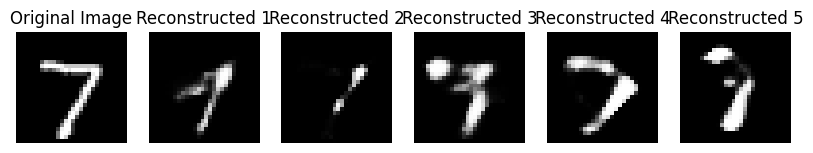

In [66]:
import torch

import matplotlib.pyplot as plt

# Select an image from the dataset
image_index = 0
image = test_dataset[image_index][0].unsqueeze(0).to(device)

# Encode the image to obtain its latent representation
latent_representation = model.get_latent_vector(image)

# Sample 5 points around the latent representation
num_samples = 5
latent_samples = torch.randn(num_samples, latent_representation.shape[1]).to(device)
latent_samples = latent_representation + 5 * latent_samples

# Decode each sampled point
reconstructed_images = model.decoder(latent_samples)

# Convert the images to numpy arrays
image = image.cpu().detach().numpy().reshape(28, 28)
reconstructed_images = reconstructed_images.cpu().detach().numpy().reshape(num_samples, 28, 28)

# Plot the original image and the reconstructed points
plt.figure(figsize=(10, 6))
plt.subplot(1, num_samples + 1, 1)
plt.imshow(image, cmap='gray')
plt.imsave("./images/near/original.png",image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

for i in range(num_samples):
    plt.subplot(1, num_samples + 1, i + 2)
    plt.imshow(reconstructed_images[i], cmap='gray')
    plt.imsave(f"./images/near/recon_{i}.png",reconstructed_images[i], cmap='gray')
    plt.title(f'Reconstructed {i+1}')
    plt.axis('off')

plt.show()